In [1]:
'''
import datasets
'''
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"zihaoq","key":"55d7181ddd7a49ad104b26ef3702d65d"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lirilkumaramal/heart-stroke
!unzip -o heart-stroke.zip  > /dev/null

  0% 0.00/560k [00:00<?, ?B/s]
100% 560k/560k [00:00<00:00, 36.4MB/s]


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('/content/train_strokes.csv')

In [4]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0
43399,36271,Female,82.0,0,0,Yes,Private,Urban,79.48,20.6,never smoked,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


### Data pre-processing

In [5]:
data = data.dropna()
data = data.reset_index()

In [6]:
def numerical_data(raw_data):
    for i in raw_data:
        if raw_data[i].dtype == 'object':
            raw_data[i] = factorization(raw_data, i)
    return raw_data

def factorization(raw_data, col):
    return pd.factorize(raw_data[col])[0]
# numerize the data

In [7]:
data = numerical_data(data)

In [8]:
data.head()

,index,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,30468,0,58.0,1,0,0,0,0,87.96,39.2,0,0
1,3,56543,1,70.0,0,0,0,0,1,69.04,35.9,1,0
2,6,52800,1,52.0,0,0,0,0,0,77.59,17.7,1,0
3,7,41413,1,75.0,0,1,0,1,1,243.53,27.0,0,0
4,8,15266,1,32.0,0,0,0,0,1,77.67,32.3,2,0


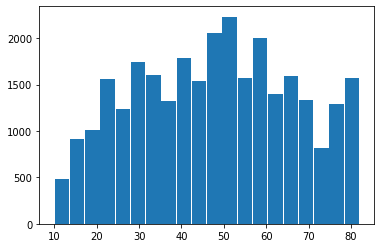

In [ ]:
plt.hist(data['age'], bins = 20,rwidth = 0.95) 
plt.show()

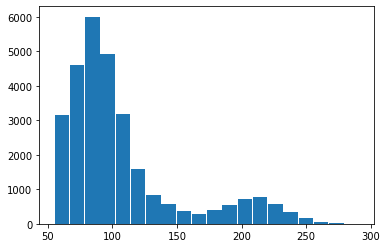

In [ ]:
plt.hist(data['avg_glucose_level'], bins = 20,rwidth = 0.95) 
plt.show()

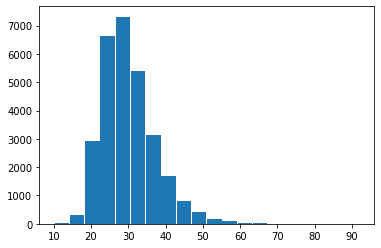

In [ ]:
plt.hist(data['bmi'], bins = 20,rwidth = 0.95) 
plt.show()

In [9]:
!pip install plotly_express
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly_express as px
from plotly.graph_objs import Line
import seaborn as sns

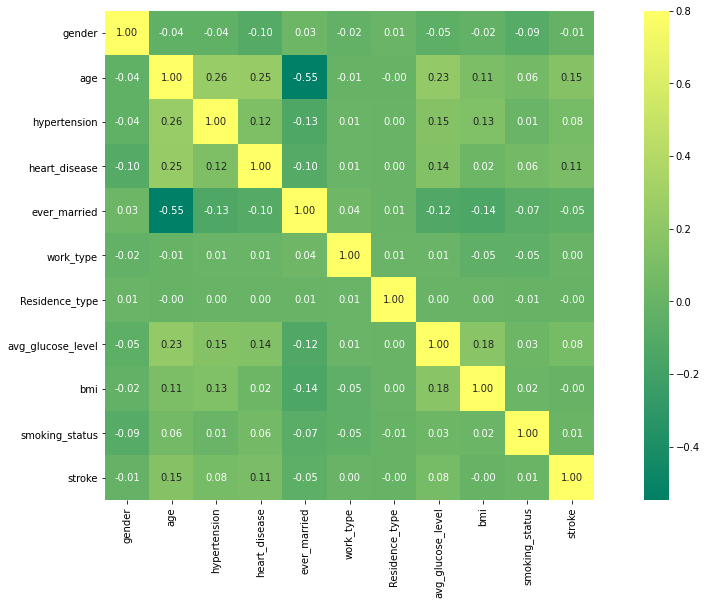

In [ ]:
plt.figure(figsize=(18, 9)) 
x_matrix = data.drop(['index', 'id'], axis=1)
corr_map = x_matrix.corr()
sns.heatmap(corr_map, vmax=1, square=True, annot=True, fmt='.2f', cmap="summer")

### tuning random forest

In [10]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import  metrics
scaler = ColumnTransformer([("norm1", SimpleImputer(missing_values=np.nan, strategy='mean'), [0,2,3,4,5,6,9]),
                            ('scaler',MinMaxScaler(),[1,7,8])
                                 ])
X = data.drop(['index', 'id','stroke'], axis=1)
X = scaler.fit_transform(X)
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [ ]:
X

array([[0.        , 1.        , 0.        , ..., 0.66666667, 0.13959498,
        0.35531136],
       [1.        , 0.        , 0.        , ..., 0.83333333, 0.05943908,
        0.31501832],
       [1.        , 0.        , 0.        , ..., 0.58333333, 0.09566175,
        0.09279609],
       ...,
       [1.        , 1.        , 0.        , ..., 1.        , 0.15645653,
        0.22954823],
       [0.        , 0.        , 0.        , ..., 0.41666667, 0.18704457,
        0.28205128],
       [1.        , 0.        , 0.        , ..., 1.        , 0.10366887,
        0.12820513]])

In [ ]:
y.shape

(29072,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True, random_state=10)  
rf.fit(X_train,y_train) 
y_pred = rf.predict_proba(X_test)[:,1] 
print(rf.oob_score_)
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test,y_pred))  

0.9803500021498903
AUC Score (Train): 0.742428


0.9803500021498903

In [ ]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10) 
param_n_estimators= {'n_estimators':range(100,301,20)} 
grid_search = GridSearchCV(estimator = rf, param_grid = param_n_estimators, 
                          cv = 5, 
                           scoring='roc_auc',
                           n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=10,
                                   

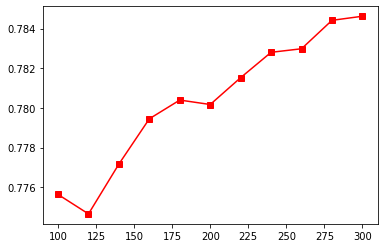

In [ ]:
plt.plot(range(100,301,20), grid_search.cv_results_['mean_test_score'], 'r-s')
plt.show()

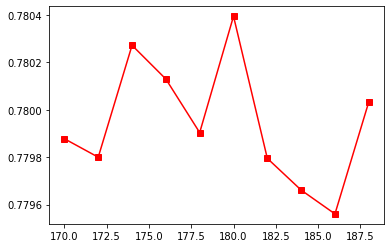

In [ ]:
from sklearn.model_selection import GridSearchCV
param_n_estimators= {'n_estimators':range(170,190,2)} 
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10)
grid_search = GridSearchCV(estimator = rf, param_grid = param_n_estimators,
                          cv = 5, scoring='roc_auc',n_jobs = -1)
grid_search.fit(X_train, y_train)
plt.plot(range(170,190,2), grid_search.cv_results_['mean_test_score'], 'r-s')
plt.show()

In [ ]:
grid_search.best_params_

{'max_depth': 4}

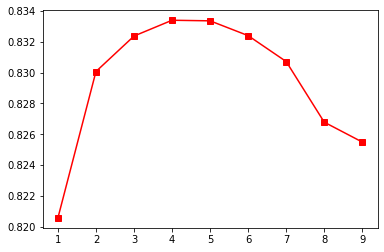

In [ ]:
param_2 = {'max_depth':range(1,10,1)}
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10,n_estimators = 180) 
grid_search = GridSearchCV(estimator = rf, 
              param_grid = param_max_depth,  
                          cv = 5, scoring='roc_auc',n_jobs = -1)
grid_search.fit(X_train, y_train)
plt.plot(range(1,10,1), grid_search.cv_results_['mean_test_score'], 'r-s')
plt.show()

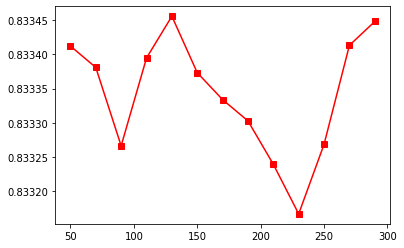

In [ ]:
param_min_samples_split= {'min_samples_split':range(50,301,20)}
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10,n_estimators = 180,max_depth = 4) 
grid_search = GridSearchCV(estimator = rf, 
              param_grid = param_min_samples_split,  
                          cv = 5, scoring='roc_auc',n_jobs = -1)
grid_search.fit(X_train, y_train)
plt.plot(range(50,301,20), grid_search.cv_results_['mean_test_score'], 'r-s')
plt.show()

In [ ]:
grid_search.best_params_

{'min_samples_split': 130}

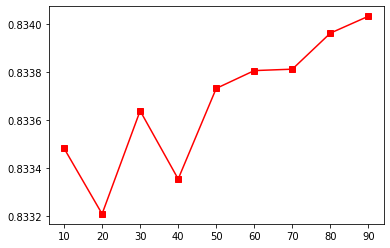

In [ ]:
param_min_samples_leaf= {'min_samples_leaf':range(10,100,10)}
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10,n_estimators = 180,max_depth = 4) 
grid_search = GridSearchCV(estimator = rf, 
              param_grid = param_min_samples_leaf,  
                          cv = 5, scoring='roc_auc',n_jobs = -1)
grid_search.fit(X_train, y_train)
plt.plot(range(10,100,10), grid_search.cv_results_['mean_test_score'], 'r-s')
plt.show()

In [ ]:
param_max= {'min_samples_leaf':range(80,141,10),'min_samples_leaf':range(120,141,10),'max_features':range(2,11,1),'max_depth':[4,5],'n_estimators':[180,300,400]}
rf = RandomForestClassifier(oob_score=True, bootstrap = True,random_state=10,) 
grid_search = GridSearchCV(estimator = rf, 
              param_grid = param_max,  
                          cv = 5, scoring='roc_auc',n_jobs = -1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=10,
                                   

In [ ]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 5,
 'min_samples_leaf': 130,
 'n_estimators': 400}

In [ ]:
grid_search.best_score_

0.836779327871308

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=130, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_gridsearch = best_grid.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test,y_pred_gridsearch)

0.9833190025795356

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=130, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [13]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=130, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [16]:
y_pred = rf.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)

0.9833190025795356

In [18]:
from sklearn.externals import joblib
joblib.dump(rf, "train_model.m")
rf2 = joblib.load("train_model.m")

In [19]:
y2_pred = rf2.predict(X_test)

metrics.accuracy_score(y_test,y2_pred)

0.9833190025795356

### input